# Image Analysis

## Import

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import argparse
import sys
import random
from tqdm import tqdm
import multiprocessing as mp

sys.path.append('../') # import를 위해 경로추가

from Modules import Utility as U

## Load data

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--path_csv', type=str, default="../data/train/train.csv")
parser.add_argument('--path_img', type=str, default="../data/train/images/")
args = parser.parse_args('')

In [3]:
train_df = pd.read_csv(args.path_csv)
images = []
for path in train_df['path']:
    __path_image = [os.path.join(*[args.path_img, path, p])  for p in os.listdir(args.path_img + path) if p[0] != '.' ]
    images.append(__path_image)
    
train_df['images'] = images

train_df.head()


,id,gender,race,age,path,images
0,000001,female,Asian,45,000001_female_Asian_45,[../data/train/images/000001_female_Asian_45/m...
1,000002,female,Asian,52,000002_female_Asian_52,[../data/train/images/000002_female_Asian_52/m...
2,000004,male,Asian,54,000004_male_Asian_54,[../data/train/images/000004_male_Asian_54/mas...
3,000005,female,Asian,58,000005_female_Asian_58,[../data/train/images/000005_female_Asian_58/m...
4,000006,female,Asian,59,000006_female_Asian_59,[../data/train/images/000006_female_Asian_59/m...


## Make data frame for images

In [4]:
image_df_labels = ['gender', 'age', 'mask', 'path']
image_df_rows = []
for _gender, _age, _images in zip(train_df['gender'], train_df['age'], train_df['images']):
    for _path in _images:
        _mask = U.ConvertImagePathToMaskStatus(_path)
        image_df_rows.append([_gender, U.AgeDecoder(U.AgeEncoder(_age)), _mask, _path])
image_df = pd.DataFrame(image_df_rows, columns=image_df_labels)
image_df['gender_class'] = [U.GenderEncoder(g.capitalize()) for g in image_df['gender']]
image_df['age_class'] = [U.AgeEncoder(a) for a in image_df['age']]
image_df['mask_class'] = [U.MaskEncoder(m) for m in image_df['mask']]
        

In [5]:
print('total number of images :', image_df.size / image_df.columns.size)
image_df.head()

total number of images : 18900.0


,gender,age,mask,path,gender_class,age_class,mask_class
0,female,30<=X<60,Wear,../data/train/images/000001_female_Asian_45/ma...,1,1,0
1,female,30<=X<60,NotWear,../data/train/images/000001_female_Asian_45/no...,1,1,2
2,female,30<=X<60,Wear,../data/train/images/000001_female_Asian_45/ma...,1,1,0
3,female,30<=X<60,Wear,../data/train/images/000001_female_Asian_45/ma...,1,1,0
4,female,30<=X<60,Incorrect,../data/train/images/000001_female_Asian_45/in...,1,1,1


## Calc Mean, STD RGB

In [6]:
def GetRGBFeature(img):
    _img_splited = cv2.split(img)
    return np.array([[np.average(_s), np.std(_s)] for _s in _img_splited])
temp_test = cv2.imread(image_df['path'][4])
print(GetRGBFeature(temp_test))

[[136.09054565  53.59779039]
 [146.3066864   49.55993275]
 [153.99081421  48.37803365]]


In [16]:
# features_RGB = np.zeros((len(image_df['gender']), 3, 2))

def TempF(item):
    _n = item[0]
    _gender, _age, _mask, _path = item[1]
    _img = cv2.imread(_path)
    _features = GetRGBFeature(_img)
    return _features

pool = mp.Pool(mp.cpu_count())
features_RGB = pool.map(TempF, enumerate(zip(image_df['gender'],image_df['age'],image_df['mask'],image_df['path'])))
features_RGB = np.array(features_RGB)
pool.close()
pool.join()

# for _gender, _age, _mask, _path in tqdm(zip(image_df['gender'],image_df['age'],image_df['mask'],image_df['path'])):
#     _img = cv2.imread(_path)
#     _features = GetRGBFeature(_img)

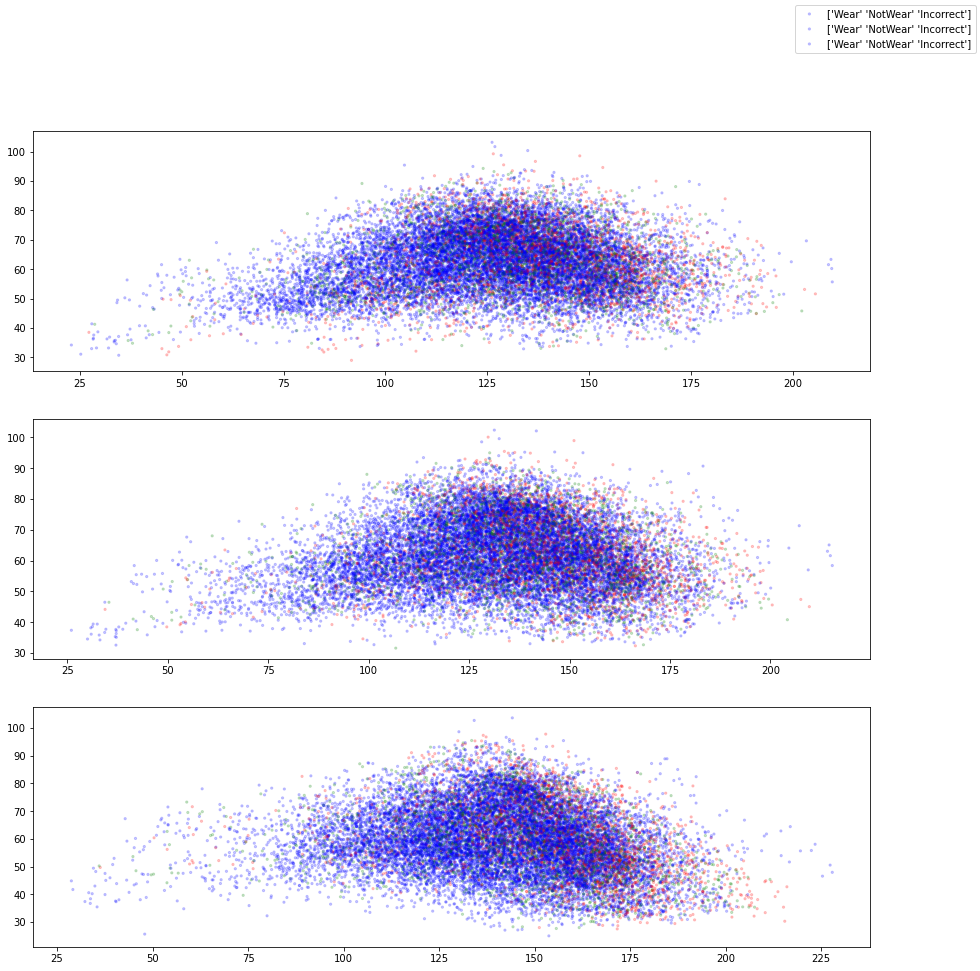

In [42]:
flt, ax = plt.subplots(3,1,figsize=(15,15))
color = ['blue', 'green', 'red']
# for i in range(100):
# # for i in range(features_RGB.shape[0]):
#     _features = features_RGB[i]
#     _s = np.sqrt(np.sum(_features[j][:]))
#     for j in range(3):
#         ax[j].scatter(_features[j][0],_features[j][1], s=_s, c=color[image_df['mask_class'][i]], label=image_df['mask'][i], alpha=0.5)
for c in range(3):
    ax[c].scatter(features_RGB[:,c,0],features_RGB[:,c,1],s=5 ,alpha=0.2, label=image_df['mask'].unique(), c=[color[i] for i in image_df['mask_class']])
flt.legend()